# Board Game Recommender - Data Scraping

This notebook walks through the process of gathering board game ratings and other descriptive info off of BoardGameGeek.com (BGG).

The first step is to import the necessary packages needed to gather and parse internet data and then to organize it into a interpretable format.

In [1]:
%matplotlib inline

import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import matplotlib.pyplot as plt 
from IPython.display import display, clear_output

We will be doing several requests to BGG, so a function is defined below with functionality to address the server returning errors for too many requests and for server errors.  By default, the function waits 1 second after the request.  This wait time doubles each time the server consecutively returns an error.

In [2]:
def politerequest(url, delay=1):
    """This function tries to get a webpage.
    If the request returns a status code 429 Too Many Requests, the program waits before the next attempt"""
    
    # make a request to the url and then wait
    r = requests.get(url)
    time.sleep(delay)
    
    # wait longer if server returns status 429 for too many requests or 5xx for server error
    n = 0
    while (r.status_code == 429) | (r.status_code >= 500):
        waittime = 2**n
        n+=1
        display('Too many attempts. Waiting ' + str(waittime) + ' seconds.')
        clear_output(wait=True)
        time.sleep(waittime)
        r = requests.get(game_url)
    return r

In order to gather game information, we will use the BGG XML API 2.  However, in order to request information from this API, we need to feed the API a "thing" ID--a unique number assigned to each entry in the BGG.  These IDs are scraped from the BGG webpage.  On [the "browse" page of BGG](https://boardgamegeek.com/browse/boardgame/page/), games are sorted by a rank determined by a proprietary formula that considers vote counts and average rating scores.  The IDs are parsed out of the URLs for each game for the top 5000 ranked games on the list.  In addition to ID numbers, game ranks and number of votes are also gathered.  These will be useful later on to minimize the number of requests to the API.

In [3]:
# base url to find board game rankings and IDs
base_url = 'https://boardgamegeek.com/browse/boardgame/page/'
game_dict = {}

# page to start on
page = 1

# set number of games to scrape info on, games will be chosen and ordered by popularity
gamecount = 5000

while len(game_dict) < gamecount:
    
    # make request and display current page on BGG; site loads 100 games per page
    r = politerequest(base_url + str(page),0.25)
    
    # iterate page
    page += 1
    
    # load page html and parse out game name, rank, ID number, and number of voter
    soup = BeautifulSoup(r.content, 'lxml')
    games = soup.find_all('div', id = re.compile('results_objectname.+?'))
    ranks = soup.find_all('td', class_ = 'collection_rank')
    nums_votersoup = soup.find_all('td', class_ = 'collection_bggrating')[2::3]
    
    # create dictionary from scraped information
    for rank, game, num_votersoup in zip(ranks, games, nums_votersoup):
        num_voters = int(num_votersoup.text)
        try:
            rank_num = rank.a.get('name')
        except:
            rank_num = None
        if (rank_num is not None) & (num_voters >= 100):
            game_id = re.search('boardgame/(.+?)/', str(game)).group(1)
            game_name = game.a.get_text()
            game_rank = rank_num
            game_dict[game_id] = {'name': game_name, 'rank': game_rank, 'num_voters': num_voters}
    
    # update display progress
    clear_output(wait=True)
    display('Done gathering '+str(len(game_dict))+' of '+str(gamecount)+' game IDs, names, and rankings.')

# update display when finished
clear_output(wait=True)
display('Done gathering '+str(len(game_dict))+' game IDs, names, and rankings.')

'Done gathering 5077 game IDs, names, and rankings.'

Information for multiple games can be accessed from the API at once.  In order to do this, the list of game IDs are grouped together in "chunks" of 25.  Before grouping, the games are ordered by number of ratings.  The API only returns 100 ratings for each game at a time, so by grouping games together by similar number of ratings, we can reduce calls to the API.

In [4]:
def chunks(l, n):
    '''Iterator function to group together game IDs to reduce API requests'''
    # for item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # create an index range for l of n items:
        yield l[i:i+n]

# number of game IDs to group
chunksize = 25

# sort IDs by number of votes to minimize number of requests to API
rank_df = pd.DataFrame.from_dict(game_dict, orient = 'index')
rank_df = rank_df.sort_values('num_voters', ascending = False)

# call chunks to group IDs
id_blocks = list(chunks(list(rank_df.index), chunksize))

# join lists of IDs into strings for API requests
id_block_str = []
for id_block in id_blocks:
    id_block_str.append(','.join(id_block))

Once games are grouped, the total number of requests needed to gather all ratings can be calculated based on the distribution of vote counts per game.

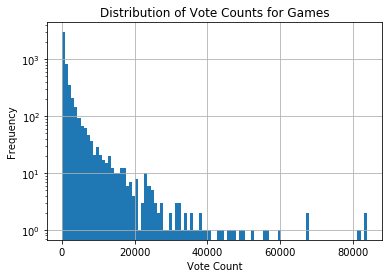

Gathering data for these 5077 games will take about 5127 requests


In [5]:
# plot histogram of game vote counts
rank_df.hist('num_voters',bins=100,log=True)
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.title('Distribution of Vote Counts for Games')
plt.show()

# calculate how many API requests to get an idea of time
vote_counts = list(rank_df.num_voters)[::chunksize]
totalpages = 0
for vote_count in vote_counts:
    totalpages += vote_count//100+1
print 'Gathering data for these '+str(len(game_dict))+' games will take about '+str(totalpages)+' requests'

Finally, all of the information for each game can be requested from the API.  The bulk of the requests are for collecting all of the ratings, as the API only returns 100 ratings per page, and some games have over 80,000 ratings (*e.g.* collecting all of the ratings for the game Pandemic requires 845 requests).

In [6]:
for index, id_block in enumerate(id_block_str,1):
    # load first page and parse out actual number of comments to determine how many pages of information to request for this block of games
    # 100 comments per page
    game_url = 'https://boardgamegeek.com/xmlapi2/thing?id='+id_block+'&stats=1&ratingcomments=1&page=1'
    r = politerequest(game_url, 1)
    soup = BeautifulSoup(r.content, 'lxml-xml')
    itemssoup = soup.findAll('item')
    ncommentpages = int(soup.find('comments')['totalitems'])//100+1
    
    for page in range(1,ncommentpages+1):
        # display progress
        clear_output(wait=True)
        display(str('Parsing page '+str(page)+' of '+str(ncommentpages)+' in block '+str(index)+' of '+str(len(id_block_str))))
        
        if page == 1:
            # gather and store important game information on the first page
            for itemsoup in itemssoup:
                id = itemsoup['id']

                attributes = {}
                attributesoup = itemsoup.findAll('link')
                for attribute in attributesoup:
                    attributes[attribute['type']] = attribute['value']

                ratings = {}
                commentsoup = itemsoup.findAll('comment')
                for comment in commentsoup:
                    ratings[comment['username']] = comment['rating']

                player_count = {}
                countsoup = itemsoup.findAll('results', numplayers = re.compile(''))
                for count in countsoup:
                    resultsoup = count.findAll('result')
                    vote_count = {}
                    for result in resultsoup:
                        vote_count[result['value']] = result['numvotes']
                    player_count[count['numplayers']] = vote_count
                
                families = []
                familysoup = itemsoup.findAll('rank')
                for family in familysoup:
                    if family['type'] == 'family':
                        families.append(family['name'])
                
                average_rating = itemsoup.average['value']
                weighted_rating = itemsoup.bayesaverage['value']
                play_time = itemsoup.playingtime['value']
                weight = itemsoup.averageweight['value']
                description = itemsoup.description.text
                year = itemsoup.yearpublished['value']
                
                game_dict[id].update({'average_rating':average_rating, 'weighted_rating':weighted_rating, 'description':description,
                                    'attributes': attributes, 'player_count': player_count, 'families':families, 'play_time':play_time, 'year':year,
                                    'weight':weight, 'ratings':ratings})

        else:
            # if there is more than 1 page, load them 1 at a time
            game_url = 'https://boardgamegeek.com/xmlapi2/thing?id='+id_block+'&stats=1&ratingcomments=1&page='+str(page)
            r = politerequest(game_url, 1)
            soup = BeautifulSoup(r.content, 'lxml-xml')
            itemssoup = soup.findAll('item')
            
            # gather and store game ratings from current page
            for itemsoup in itemssoup:
                id = itemsoup['id']
                commentsoup = itemsoup.findAll('comment')
                for comment in commentsoup:
                    game_dict[id]['ratings'][comment['username']] = comment['rating']
                    
        current_time = str(time.ctime())
        for itemsoup in itemssoup:
                id = itemsoup['id']
                game_dict[id]['last_updated'] = current_time
        
clear_output(wait=True)
display('Done')

'Done'

Now that all of the data are gathered in a dictionary, this dictionary can be converted to a DataFrame and exported.

In [7]:
game_df = pd.DataFrame.from_dict(game_dict, orient = 'index')
game_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5077 entries, 1 to 99975
Data columns (total 14 columns):
ratings            5077 non-null object
last_updated       5077 non-null object
player_count       5077 non-null object
num_voters         5077 non-null int64
name               5077 non-null object
weight             5077 non-null object
rank               5077 non-null object
average_rating     5077 non-null object
year               5077 non-null object
families           5077 non-null object
play_time          5077 non-null object
attributes         5077 non-null object
weighted_rating    5077 non-null object
description        5077 non-null object
dtypes: int64(1), object(13)
memory usage: 595.0+ KB


In [8]:
game_df.to_json('bgg_database.json')
game_df.head()

,ratings,last_updated,player_count,num_voters,name,weight,rank,average_rating,year,families,play_time,attributes,weighted_rating,description
1,"{u'aSoso': u'10', u'Annagul': u'7', u'the_ka':...",Tue Mar 19 03:05:58 2019,"{u'1': {u'Recommended': u'1', u'Not Recommende...",4762,Die Macher,4.3443,218,7.63445,1986,[strategygames],240,"{u'boardgamedesigner': u'Karl-Heinz Schmiel', ...",7.19502,Die Macher is a game about seven sequential po...
10,"{u'Igorken': u'6', u'druvey': u'4', u'Joverowa...",Tue Mar 19 02:27:37 2019,"{u'6+': {u'Recommended': u'1', u'Not Recommend...",7353,Elfenland,2.1625,862,6.73148,1998,[familygames],60,"{u'boardgamedesigner': u'Alan R. Moon', u'boar...",6.53778,Elfenland is a redesign of the original White ...
100169,"{u'dougadamsau': u'8', u'cayluster': u'8.5', u...",Tue Mar 19 05:07:46 2019,"{u'1': {u'Recommended': u'1', u'Not Recommende...",148,Hero of Weehawken,2.1579,3991,7.58219,2011,[thematic],45,"{u'boardgamedesigner': u'Robert Leonhard', u'b...",5.72384,Historic Gaming #7&#10;&#10;Hero of Weehawken ...
1002,"{u'dakarp': u'8', u'hurrlipurr': u'7', u'sanny...",Tue Mar 19 04:55:28 2019,"{u'1': {u'Recommended': u'0', u'Not Recommende...",444,Cosmic Eidex,2.6786,2820,6.90013,1998,[strategygames],60,"{u'boardgamedesigner': u'Urs Hostettler', u'bo...",5.87115,Cosmic Eidex is an intriguing little trick-tak...
100423,"{u'Igorken': u'7', u'sterry221': u'9', u'the_k...",Tue Mar 19 00:08:24 2019,"{u'8+': {u'Recommended': u'1', u'Not Recommend...",19106,Elder Sign,2.3571,491,7.007,2011,[thematic],90,"{u'boardgamedesigner': u'Kevin Wilson', u'boar...",6.85712,Game description from the publisher:&#10;&#10;...
